# Metropolis Monte Carlo Method
#### Jakub Dawidowicz
## Task 1: Average Energy and Heat Capacity

### Part a and c

The pseudo code has been translated into python with the main sections of the code commented below

E av = 2.7435535954986185e-21
E^2 av = 2.2420828738940591e-41
Cv = 9.038013476283266e-24


Text(0, 0.5, 'Count')

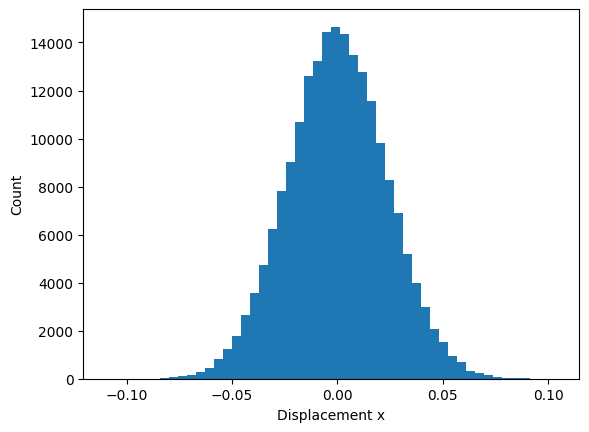

In [259]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

##Initialisation 
deltax = 0.15
nm = 1e-9
k = 1.831e-23
T = 300.0
kT = k * T
kf = 10.0
N= 200000
 
def V(x):
    return (kf * (x**2) * (nm**2))/2



#Graph setup to check distribution
x=[]

def mmc(N):        
    Etot = 0.0
    E2tot = 0.0
    Xtot = 0.0
    X2tot = 0.0
    x1 = 0.0
    E1 = V(x1)
    
    ##Monte Carlo loop
    for i in range(N): 
        x2 = x1 + (np.random.rand()-0.5)*deltax
        E2 = V(x2)
        deltaE = E2 - E1
        if deltaE <= 0.0:
            x1 = x2
            E1 = E2
        elif np.exp(-deltaE/kT) > np.random.rand():
            x1 = x2
            E1 = E2
        x.append(x1)
        ## Data calculation
        Etot += E1
        E2tot += E1**2
        ## Average displacement
        Xtot += x1
        X2tot += x1**2


    ##Analysis
    Eav = Etot/N
    E2av = E2tot/N
    CV = (E2av-(Eav**2))/(k*(T**2))
    return Eav, E2av, CV, Xtot, X2tot


Eav, E2av, CV, Xtot, X2tot = mmc(N)
print(f'E av = {Eav}')
print(f'E^2 av = {E2av}')
print(f'Cv = {CV}')
plt.hist(x, bins=50)
plt.xlabel('Displacement x')
plt.ylabel('Count')


The values achieved appear to be of the right order, however they are always slightly higher than expected. I am unsure why this is the case, as looking at the histogram the importance sampling appears to behave as expected with a Boltzmann distribution in both the positive and negative, with higher energies having lower probabilities.

### Part b: Mistakes in the pseudo code
1. kf variable is declared twice
2. The random walk is not executed correctly, it needs to have positive and negative movement
3. Eav is not calculated correctly, it needs to be Etot/N
4. Etot is not calculated correctly, it needs to be Etot + E1
 

## Part d: Verifying with theoretical value

Performing the integral 

$$ V =\frac{1}{2}k_{f} \frac{\int x^{2} e^{\frac{-x^{2}k_{f}}{2kT}}dx}{\int e^{\frac{-x^{2}k_{f}}{2kT}}dx}

In [260]:
def exponent(xdisp):
    return np.exp(-((xdisp**2)*kf)/2*kT)

def top_half(xdisp):
    return (xdisp**2)*exponent(xdisp)

top_int = integrate.quad(top_half, -1000000, 100000)[0]
bot_int = integrate.quad(exponent, -1000000, 100000)[0]

V_theory = (kf/2)*(top_int)/(bot_int)
print(V_theory)

1516666654333.6604


Also don't think this is correct, the numerical routine will not allow me to the limites of infinity, however perhaps my integrals are set up incorrectly

## Task 2: Average Displacement

### Part a
Typical value for 
$$ \langle x \rangle \equiv X_{tot}/N $$

In [261]:
print(f'Xav = {(Xtot/N)*nm} nm')

Xav = 5.298829467878227e-14 nm


This result is very close to 0 which is expected. There should be equal probability distributions in both positive and negative displacement which in a perfect world would average out to 0 displacement. Due to randomness it will be shifted slightly to one side or the other which can be seen in the value jumping to slightly positive or negative if ran multiple times.

### Part b
Typical value for:
$$ \langle x^{2} \rangle \equiv X_{tot}/N $$
compared to theoretical for $ kT/k_{f} = 0.00041 nm^{2} $

In [262]:
print(f'X2av = {(X2tot/N)}  nm^2')
print(f'kT/kf = 0.000414 nm^2')

X2av = 0.0005487107190997262  nm^2
kT/kf = 0.000414 nm^2



$$ E  = \frac{kT}{2} $$
Harmonic oscillator has potential energy
$$ V = \frac{k_{f}x^{2}}{2} $$
So
$$ x^{2} = \frac{kT}{k_{f}}

We would expect these values to be very close, which they are, they are of similair order, however still all the values I am achieving apart from $ \langle x \rangle $ are slightly larger than expected for a reason I cannot find.

## Task 3: Understanding

The metropolis monte carlo method works due to importance sampling. In this example, lower energy states are much more likely, and therefore make a much higher contribution to the statistical average, whereas higher energy states are much less likely and make a lower contribution. Because we are concerned about energy states, this statement is in line with a Boltzmann distribution. We take samples according to this probability space. 
In our code, this is done in a few steps (after our initial guess for $ x_{1} $). 
1. We generate a random walk for our sample $ x_{1} \rightarrow x_{2} $ (Markov process).
2. We compare the energy states of our samples $ E(x_{1}) $ and $ E(x_{2}) $.
3. If the new energy state is lower, i.e $ E_{2} < E_{1} $, we accept the new sample, and repeat from step 1.
4. If the new energy state is higher, i.e $ E_{2} > E_{1} $, we assess the probability of the new state compared to the old one, in this case using the Boltzmann factor, which is given by :
$$ \frac{P_{2}}{P_{1}} = \frac{e^{\frac{-E_{2}}{kT}}}{e^{\frac{-E_{1}}{kT}}} = e^{-\Delta E/kT} $$
where $ \Delta E = E_{2} - E_{1}$, $ T $ is the temperature of the system, and $ k $ is the Boltzmann constant.
5. We generate a uniform random number $ r $ and compare it to this factor. If the factor is higher than $ r $ we accept the new sample, and repeat from step 1.
6. If the factor is lower on the other hand, we reject the new walk and keep the old state (whilst still adding the old as another data point).

These steps ensure a couple of key elements required for the Metropolis algorithm. The first is we are always accepting lower energy or more probable states in our random walks in sample space. Second, we are conditionally accepting higher energy states based on the detailed balance we impose between states, in this case the Boltzmann factor. 
As an example, in the histogram above, very small walks to slightly higher energy say, $ x = 0 \rightarrow 0.001 $ have a 91% chance of being accepted, whereas very large walks to much higher energies have a very small chance of being accepted, $ x = 0 \rightarrow 0.0075 $ is just a 0.5% chance.
Again since this balance of acceptance is based on the Boltzmann factor, the resulting samples are in a Boltzmann distribution.

## Task 4: Error Calculations

Calculate the fractional error for different values of N using the following equation:
$$ \frac{\sigma}{\langle E \rangle} = \frac{\sqrt{kT^{2}C_{V}}}{\langle E \rangle}


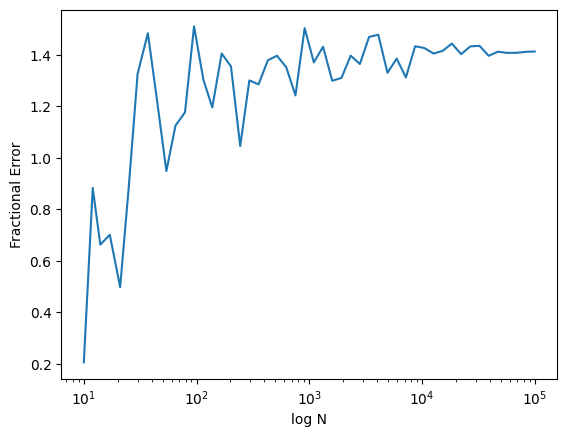

In [263]:
def frac_error(C, Eav):
    return (np.sqrt(k*(T**2)*C))/Eav

Nlist = []
error_list = []
for i in np.linspace(1,5,50):
    N=int(10**i)
    Nlist.append(N)
    Eav, E2av, CV, Xtot, X2tot = mmc(N)
    error_list.append(frac_error(CV,Eav))


plt.xscale('log')
plt.xlabel('log N')
plt.ylabel('Fractional Error')
plt.plot(Nlist,error_list)

This graph produces some interesting results, I would expect to see the error reduce in proportion to $ 1/\sqrt{N} $ however the graph has large variations until it stabilises at a fractional error of around 1.4/1.5, which initially is much higher than I was expecting. To compare I have plotted $ 1\sqrt{N} $ against $ N $ below

Text(0, 0.5, '1/sqrt(N)')

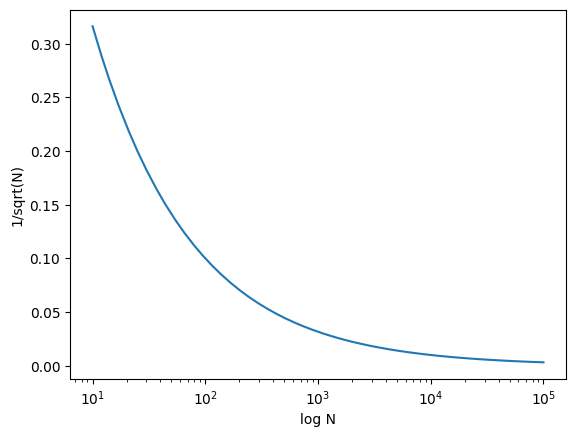

In [264]:
rtN = []
for i in Nlist:
    rtN.append(1/np.sqrt(i))
plt.plot(Nlist, rtN)
plt.xscale('log')
plt.xlabel('log N')
plt.ylabel('1/sqrt(N)')